# Task 3: Predictive Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve

KeyboardInterrupt: 

## Loading the Customer Profile model

In [ ]:
df_customer_profile = pd.read_csv('dataset/customer_profile_kmeans.csv', sep='\t', index_col=0) # e.g., customer_profile_fcmeans or customer_profile_birch
df_customer_profile

,I,Iu,Imax,E,Savg,F,M,cluster
CustomerID,,,,,,,,
12347.0,3.330211,1.939519,2.829947,4.239118,2.777935,0.778151,3.556087,high
12348.0,3.035029,0.954243,2.778151,2.550341,2.417438,0.477121,2.894560,medium
12349.0,2.799341,1.857332,2.799341,3.903268,3.163623,0.000000,3.163623,high
12350.0,2.292256,1.204120,2.292256,2.500000,2.468938,0.000000,2.468938,medium
12352.0,2.665581,1.755875,2.096910,3.158366,2.324080,0.778151,3.102231,medium
...,...,...,...,...,...,...,...,...
18280.0,1.653213,1.000000,1.653213,1.846439,2.256718,0.000000,2.256718,low
18281.0,1.732394,0.845098,1.732394,1.842371,1.907519,0.000000,1.907519,low
18282.0,1.991226,1.079181,1.845098,3.022055,1.945961,0.301030,2.246991,low


In [ ]:
customer_profile = df_customer_profile.to_numpy()

In [ ]:
def plot_learning_curve(pipeline, X, y, scorer='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), 
                        shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(pipeline, X, y, train_sizes=train_sizes, cv=cv,
                                                            scoring=scorer, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(pipeline['estimator'].__class__.__name__) + ' learning curve')
    plt.xlabel('training set size')
    plt.ylabel('score')

    plt.plot(train_sizes, mean_train_score, label='train score', color='navy', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_train_score + std_train_score,
                     mean_train_score - std_train_score, color='navy', alpha=0.2)
    plt.plot(train_sizes, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(train_sizes, mean_test_score + std_test_score,
                     mean_test_score - std_test_score, color='darkorange', alpha=0.2)

    plt.legend(loc='lower right').get_frame().set_facecolor('white')


def plot_validation_curve(pipeline, X, y, param_grid, param_name, scorer='accuracy', cv=5):
    
    param_range = param_grid[param_name]
    train_scores, test_scores = validation_curve(pipeline, X, y, param_name=param_name, param_range=param_range,
                                                 cv=cv, scoring=scorer, n_jobs=-1)

    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    plt.title(str(pipeline['estimator'].__class__.__name__) + ' validation curve')
    plt.xlabel(param_name)
    plt.ylabel('score')

    plt.plot(param_range, mean_train_score, label='training score', color='navy', marker='.', lw=2)
    plt.fill_between(param_range, mean_train_score - std_train_score,
                     mean_train_score + std_train_score, alpha=0.2, color='navy')
    plt.plot(param_range, mean_test_score, label='cross-validation score', color='darkorange', marker='.', lw=2)
    plt.fill_between(param_range, mean_test_score - std_test_score,
                     mean_test_score + std_test_score, alpha=0.2, color='darkorange')

    plt.legend(loc='lower right').get_frame().set_facecolor('white')


def print_pretty_cv_results(grid):
    df = pd.DataFrame(grid.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')
    df['params'] = df['params'].apply(lambda param_dict: {k.replace('estimator__', ''): v for k, v in param_dict.items()})
    df.rename(columns={'mean_test_score': 'mean_val_score', 
                       'rank_test_score': 'rank_val_score'}, inplace=True)
    
    def highlight_equal(s, value, column):
        is_max = pd.Series(data=False, index=s.index)
        is_max[column] = s.loc[column] == value
        return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

    return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()

## Splitting train and test set

In [ ]:
X, y = customer_profile[:, :-1], customer_profile[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

## Support Vector Classifier

In [ ]:
from sklearn.svm import SVC

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', SVC())])

tuned_parameters = {'estimator__C': (1, 10, 100, 1000)}

svc_grid = GridSearchCV(pipeline,
                        param_grid=tuned_parameters,
                        scoring='accuracy',
                        cv=5,  # 5 fold cross validation
                        n_jobs=-1,  # use all processors
                        refit=True,  # refit the best model on the full development set
                        return_train_score=True,
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [ ]:
print_pretty_cv_results(svc_grid)

C:\Users\akila\AppData\Local\Temp\ipykernel_13376\3005877394.py:63: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
{'C': 10},0.995243,0.990485,1
{'C': 100},0.997939,0.989851,2
{'C': 1000},0.999921,0.988584,3
{'C': 1},0.991516,0.984776,4


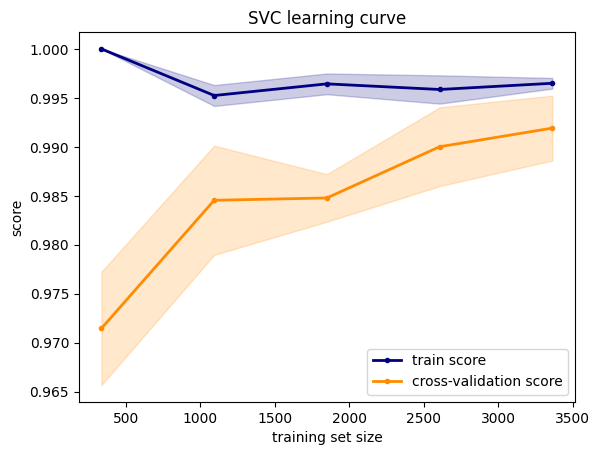

In [ ]:
plot_learning_curve(svc_grid.best_estimator_, X, y)

plt.savefig('tex/img/classification/svm_lc.png')

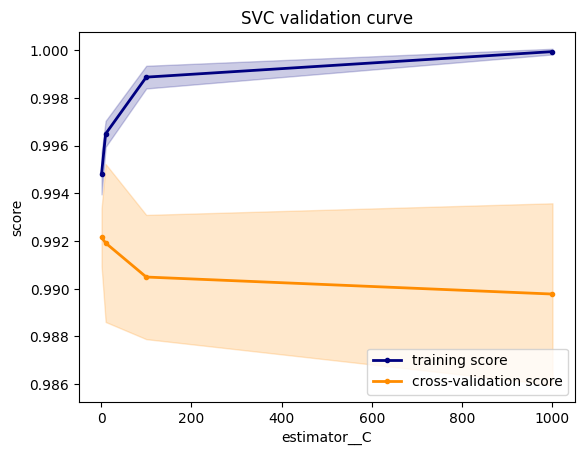

In [ ]:
plot_validation_curve(svc_grid.best_estimator_, X, y, param_grid=tuned_parameters, param_name='estimator__C')

plt.savefig('tex/img/classification/svm_vc.png')

### Evaluation on the test set

In [ ]:
y_pred = svc_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9933460076045627

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.99      1.00      0.99       312
         low       1.00      1.00      1.00       232
      medium       1.00      0.99      0.99       508

    accuracy                           0.99      1052
   macro avg       0.99      0.99      0.99      1052
weighted avg       0.99      0.99      0.99      1052



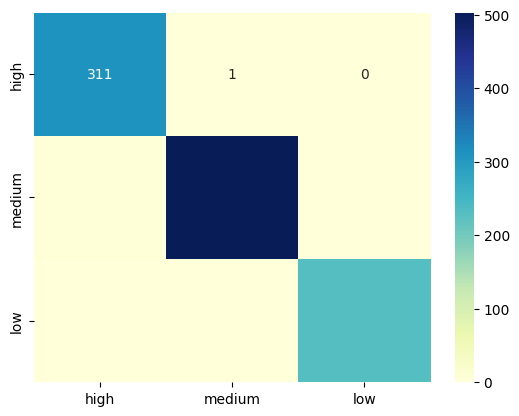

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

plt.savefig('tex/img/classification/svm_confusion.png')

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', MLPClassifier())])

tuned_parameters = {'estimator__hidden_layer_sizes': ((50,), (100,), (150,)), 
                    'estimator__activation': ('logistic', 'tanh'), 
                    'estimator__solver': ('lbfgs',)}

mlp_grid = GridSearchCV(pipeline,
                        param_grid=tuned_parameters,
                        scoring='accuracy',
                        cv=5,  # 5 fold cross validation
                        n_jobs=-1,  # use all processors
                        refit=True,  # refit the best model on the full development set
                        return_train_score=True,
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [ ]:
print_pretty_cv_results(mlp_grid)

C:\Users\akila\AppData\Local\Temp\ipykernel_13376\3005877394.py:63: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
"{'activation': 'tanh', 'hidden_layer_sizes': (150,), 'solver': 'lbfgs'}",1.000000,0.997464,1
"{'activation': 'logistic', 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}",1.000000,0.996195,2
"{'activation': 'tanh', 'hidden_layer_sizes': (50,), 'solver': 'lbfgs'}",1.000000,0.994927,3
"{'activation': 'logistic', 'hidden_layer_sizes': (150,), 'solver': 'lbfgs'}",1.000000,0.994925,4
"{'activation': 'logistic', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}",1.000000,0.994608,5
"{'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}",1.000000,0.994607,6


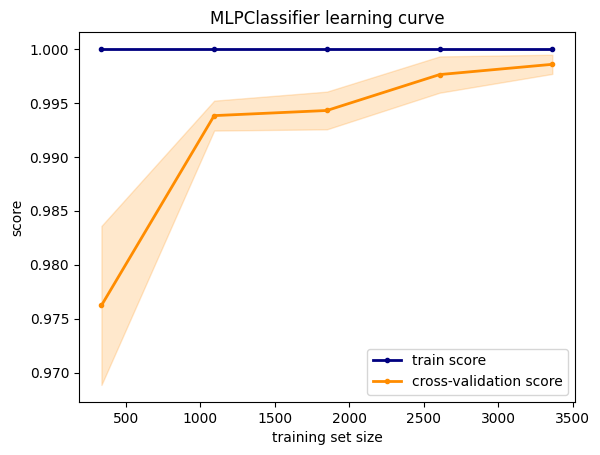

In [ ]:
plot_learning_curve(mlp_grid.best_estimator_, X, y)

plt.savefig('tex/img/classification/nn_lc.png')

### Evaluation on the test set

In [ ]:
y_pred = mlp_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9990494296577946

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       1.00      1.00      1.00       312
         low       1.00      1.00      1.00       232
      medium       1.00      1.00      1.00       508

    accuracy                           1.00      1052
   macro avg       1.00      1.00      1.00      1052
weighted avg       1.00      1.00      1.00      1052



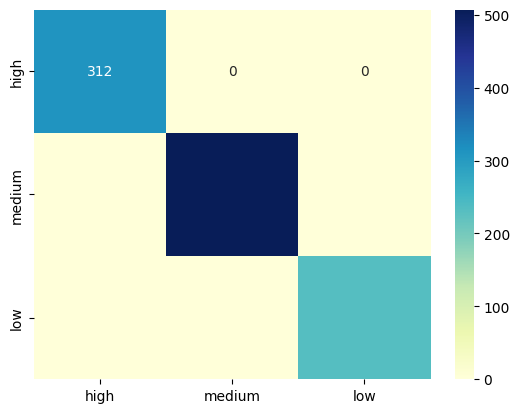

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

plt.savefig('tex/img/classification/nn_confusion.png')

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', GaussianNB())])

gnb_grid = GridSearchCV(pipeline, 
                        param_grid={}, 
                        scoring='accuracy', 
                        cv=5,  # 5 fold cross validation 
                        n_jobs=-1,  # use all processors 
                        refit=True,  # refit the best model on the full development set 
                        return_train_score=True, 
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
print_pretty_cv_results(gnb_grid)

C:\Users\akila\AppData\Local\Temp\ipykernel_13376\3005877394.py:63: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
{},0.975737,0.974308,1


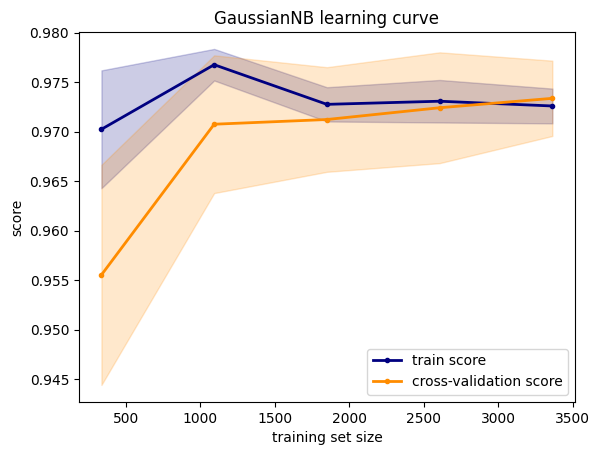

In [ ]:
plot_learning_curve(gnb_grid.best_estimator_, X, y)

plt.savefig('tex/img/classification/nb_lc.png')

### Evaluation on the test set

In [ ]:
y_pred = gnb_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9610266159695817

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.97      0.98      0.97       312
         low       0.94      0.95      0.95       232
      medium       0.97      0.95      0.96       508

    accuracy                           0.96      1052
   macro avg       0.96      0.96      0.96      1052
weighted avg       0.96      0.96      0.96      1052



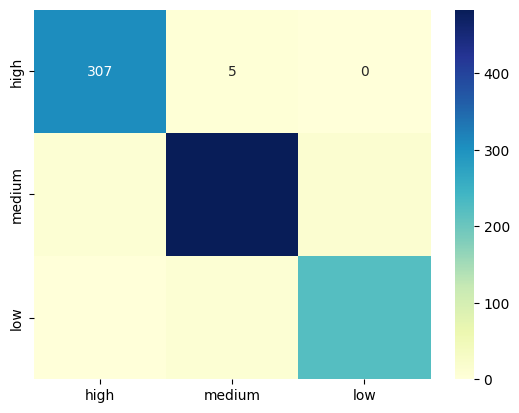

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

plt.savefig('tex/img/classification/nb_confusion.png')

## K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', KNeighborsClassifier())])

tuned_parameters = {'estimator__n_neighbors': (30, 50, 55, 60, 65, 70, 75, 80, 85, 100),
                    'estimator__weights': ('uniform', 'distance')}

knn_grid = GridSearchCV(pipeline,
                        param_grid=tuned_parameters,
                        scoring='accuracy',
                        cv=5,  # 5 fold cross validation
                        n_jobs=-1,  # use all processors
                        refit=True,  # refit the best model on the full development set
                        return_train_score=True,
                        verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
print_pretty_cv_results(knn_grid)

C:\Users\akila\AppData\Local\Temp\ipykernel_13376\3005877394.py:63: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
"{'n_neighbors': 60, 'weights': 'distance'}",1.000000,0.979699,1
"{'n_neighbors': 55, 'weights': 'distance'}",1.000000,0.979383,2
"{'n_neighbors': 50, 'weights': 'distance'}",1.000000,0.979383,3
"{'n_neighbors': 30, 'weights': 'distance'}",1.000000,0.979065,4
"{'n_neighbors': 30, 'weights': 'uniform'}",0.981922,0.979064,5
"{'n_neighbors': 50, 'weights': 'uniform'}",0.980257,0.978749,6
"{'n_neighbors': 65, 'weights': 'distance'}",1.000000,0.978431,7
"{'n_neighbors': 60, 'weights': 'uniform'}",0.979940,0.977481,8
"{'n_neighbors': 70, 'weights': 'uniform'}",0.977958,0.976528,9
"{'n_neighbors': 70, 'weights': 'distance'}",1.000000,0.976211,10


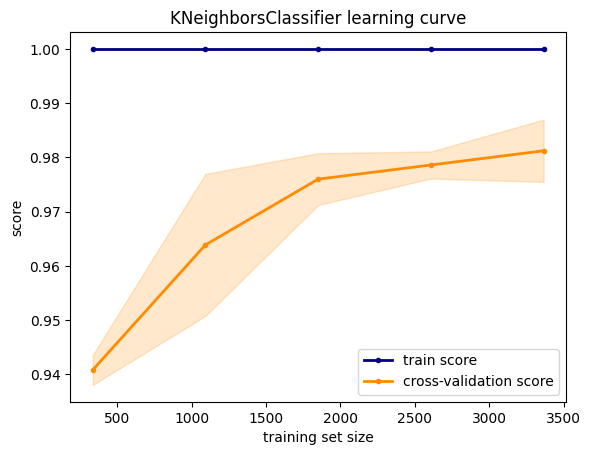

In [ ]:
plot_learning_curve(knn_grid.best_estimator_, X, y)

plt.savefig('tex/img/classification/knn_lc.png')

### Evaluation on the test set

In [ ]:
y_pred = knn_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9809885931558935

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       1.00      0.97      0.99       312
         low       0.99      0.96      0.98       232
      medium       0.97      0.99      0.98       508

    accuracy                           0.98      1052
   macro avg       0.99      0.98      0.98      1052
weighted avg       0.98      0.98      0.98      1052



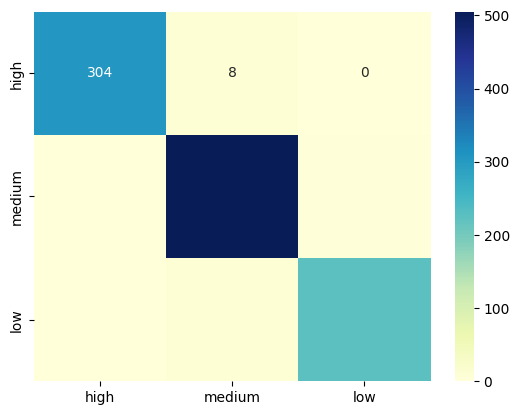

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

plt.savefig('tex/img/classification/knn_confusion.png')

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', RandomForestClassifier())])

tuned_parameters = {'estimator__n_estimators': (10, 100, 1000, 1500, 2000), 
                    'estimator__bootstrap': (True, False), 
                    'estimator__max_depth': (10, 30, 60, 100), 
                    'estimator__min_samples_split': (2, 5, 10), 
                    'estimator__min_samples_leaf': (1, 2, 4), 
                    'estimator__max_features': (1, 'auto', 5)}

rf_grid = GridSearchCV(pipeline, 
                       param_grid=tuned_parameters, 
                       scoring='accuracy', 
                       cv=5,  # 5 fold cross validation
                       n_jobs=-1,  # use all processors 
                       refit=True,  # refit the best model on the full development set 
                       return_train_score=True, 
                       verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


C:\Users\akila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [ ]:
print_pretty_cv_results(rf_grid)

C:\Users\akila\AppData\Local\Temp\ipykernel_13376\3005877394.py:63: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
"{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.969868,1
"{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}",1.000000,0.969236,2
"{'bootstrap': True, 'max_depth': 60, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}",1.000000,0.969236,3
"{'bootstrap': True, 'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",1.000000,0.969236,3
"{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}",1.000000,0.969235,5
"{'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}",1.000000,0.968919,6
"{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.968919,6
"{'bootstrap': True, 'max_depth': 100, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.968918,8
"{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1500}",1.000000,0.968601,9
"{'bootstrap': True, 'max_depth': 60, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}",1.000000,0.968601,9


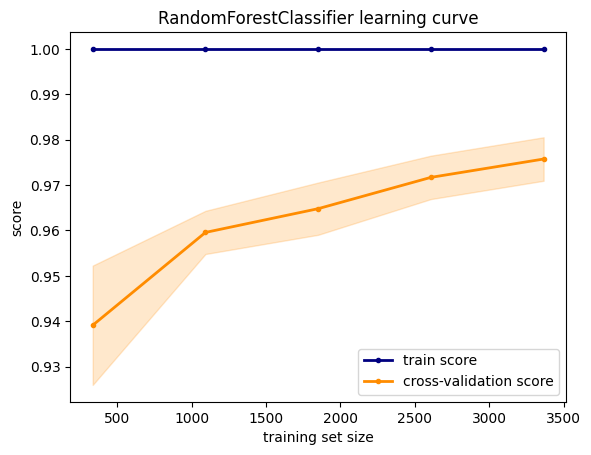

In [ ]:
plot_learning_curve(rf_grid.best_estimator_, X, y)

plt.savefig('tex/img/classification/rf_lc.png')

### Evaluation on the test set

In [ ]:
y_pred = rf_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.964828897338403

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.97      0.96      0.97       312
         low       0.98      0.94      0.96       232
      medium       0.95      0.98      0.96       508

    accuracy                           0.96      1052
   macro avg       0.97      0.96      0.96      1052
weighted avg       0.97      0.96      0.96      1052



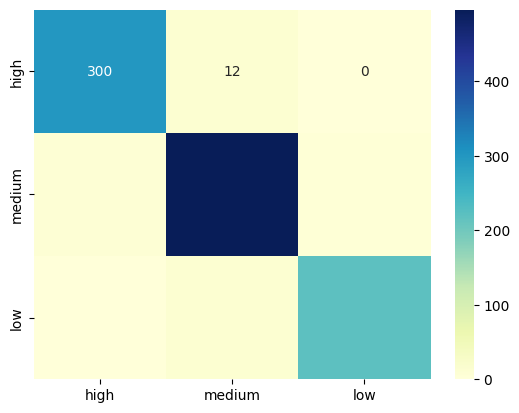

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

plt.savefig('tex/img/classification/rf_confusion.png')

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('estimator', DecisionTreeClassifier())])

tuned_parameters = {'estimator__splitter': ('best', 'random'),
                    'estimator__max_depth': (10, 30, 60, 100, 200, 500),
                    'estimator__min_samples_split': (2, 5, 10, 15, 20, 30),
                    'estimator__min_samples_leaf': (1, 2, 4, 7, 10, 15),
                    'estimator__max_features': (1, 'auto', 5, 7, 10, 15),
                    'estimator__criterion': ('gini', 'entropy')}

dt_grid = GridSearchCV(pipeline,
                       param_grid=tuned_parameters,
                       scoring='accuracy',
                       cv=5,  # 5 fold cross validation
                       n_jobs=-1,  # use all processors
                       refit=True,  # refit the best model on the full development set
                       return_train_score=True,
                       verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 5184 candidates, totalling 25920 fits


In [ ]:
print_pretty_cv_results(dt_grid)

C:\Users\akila\AppData\Local\Temp\ipykernel_13376\3005877394.py:63: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  return df.head(15).style.apply(highlight_equal, value=1, column=['rank_val_score'], axis=1).hide_index()


params,mean_train_score,mean_val_score,rank_val_score
"{'criterion': 'entropy', 'max_depth': 500, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.994767,0.950203,1
"{'criterion': 'entropy', 'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.996591,0.949572,2
"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.996115,0.949571,3
"{'criterion': 'entropy', 'max_depth': 30, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}",1.000000,0.949571,4
"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.996670,0.949254,5
"{'criterion': 'entropy', 'max_depth': 200, 'max_features': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.996591,0.948938,6
"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.994450,0.948618,7
"{'criterion': 'entropy', 'max_depth': 100, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.994846,0.948616,8
"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}",0.996274,0.948305,9
"{'criterion': 'entropy', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}",0.999445,0.948304,10


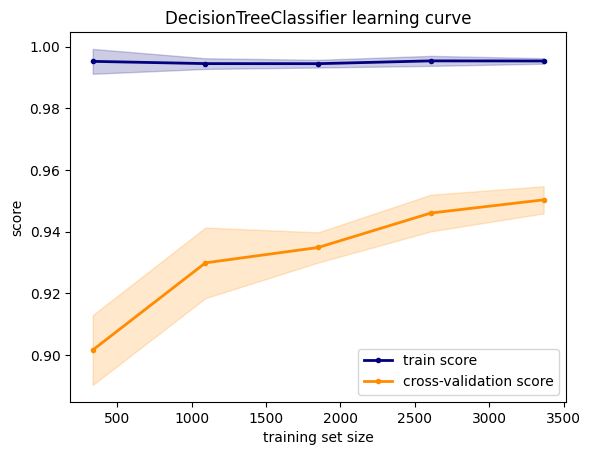

In [ ]:
plot_learning_curve(dt_grid.best_estimator_, X, y)

plt.savefig('tex/img/classification/dt_lc.png')

### Evaluation on the test set

In [ ]:
y_pred = dt_grid.best_estimator_.predict(X_test)
accuracy_score(y_pred, y_test)

0.9534220532319392

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.98      0.96      0.97       312
         low       0.95      0.91      0.93       232
      medium       0.94      0.97      0.95       508

    accuracy                           0.95      1052
   macro avg       0.96      0.95      0.95      1052
weighted avg       0.95      0.95      0.95      1052



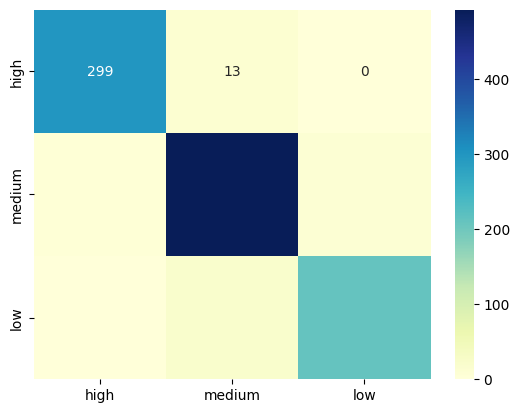

In [ ]:
confusion = pd.DataFrame(confusion_matrix(y_test, y_pred, labels=['high', 'medium', 'low']), 
                         columns=['high', 'medium', 'low'], index=['high', 'medium', 'low'])
sns.heatmap(confusion, annot=True, fmt='g', cmap='YlGnBu');

plt.savefig('tex/img/classification/dt_confusion.png')

In [ ]:
import pydotplus
from IPython.display import Image 

dot_data = export_graphviz(dt_grid.best_estimator_['estimator'], 
                           feature_names=df_customer_profile.columns[:-1], 
                           class_names=df_customer_profile['cluster'].unique(), 
                           out_file=None, 
                           filled=True, 
                           rounded=True) 
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('tex/img/classification/decision_tree.png')
Image(pydot_graph.create_png())

InvocationException: GraphViz's executables not found